In [ ]:
# Import files from google drive
from google.colab import files
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [ ]:
# Unzip dataset
!unzip Dataset

Archive:  Dataset.zip
  inflating: Dataset/mHealth_subject1.log  
  inflating: Dataset/mHealth_subject10.log  
  inflating: Dataset/mHealth_subject2.log  
  inflating: Dataset/mHealth_subject3.log  
  inflating: Dataset/mHealth_subject4.log  
  inflating: Dataset/mHealth_subject5.log  
  inflating: Dataset/mHealth_subject6.log  
  inflating: Dataset/mHealth_subject7.log  
  inflating: Dataset/mHealth_subject8.log  
  inflating: Dataset/mHealth_subject9.log  


In [ ]:
# Import relevant libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import _pickle as cPickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle
import sys
import os

files=os.listdir("Dataset/")
folder="Dataset/"

In [ ]:
features=[]
labels=[]

# loop over all files to get features and labels
with tqdm(total=len(files)) as pbar:
    for f1 in files:
        name=folder+f1
        f = open(name, 'r')
        x=f.readline()
        while(x):
            x=x.split()
            labels.append(int(x[-1]))
            del x[-1]
            sublist=[]
            for val in x:
                sublist.append(val)
            features.append(np.array(sublist))
            x=f.readline()
        pbar.update(1)

# Convert to an array
features=np.array(features)
labels=np.array(labels)

# Print shape of features and labels
print(features.shape)
print(labels.shape)

# Print unique labels
print(np.unique(labels))

#saving for future use
with open("features", 'wb') as fp:
    pickle.dump(features, fp)

with open("labels", 'wb') as fp:
    pickle.dump(labels, fp)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


(1215745, 23)
(1215745,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from matplotlib import style
import string
from collections import Counter
import sys
import pickle
import glob
from keras.layers import Dense
from keras.layers import SeparableConv1D,MaxPooling1D, LSTM
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [ ]:
# getting data
with open('features', 'rb') as fp:
    X=pickle.load(fp)

with open('labels', 'rb') as fp:
    y=pickle.load(fp)

In [ ]:
# encoding labels to one hot form
oh=OneHotEncoder()
y=oh.fit_transform(np.reshape(y,(-1,1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [ ]:
# splitting data in train and testing
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42, shuffle=True)

X_train=np.expand_dims(X_train,axis=2)
X_test=np.expand_dims(X_test,axis=2)

Train on 972596 samples, validate on 243149 samples
Epoch 1/20
972596/972596 [==============================] - 712s 732us/step - loss: 0.5844 - acc: 0.7697 - val_loss: 0.4829 - val_acc: 0.7978
Epoch 2/20
972596/972596 [==============================] - 738s 759us/step - loss: 0.4871 - acc: 0.7970 - val_loss: 0.4522 - val_acc: 0.8046
Epoch 3/20
972596/972596 [==============================] - 750s 771us/step - loss: 0.4631 - acc: 0.8062 - val_loss: 0.4426 - val_acc: 0.8110
Epoch 4/20
972596/972596 [==============================] - 740s 761us/step - loss: 0.4505 - acc: 0.8116 - val_loss: 0.4309 - val_acc: 0.8136
Epoch 5/20
972596/972596 [==============================] - 749s 770us/step - loss: 0.4424 - acc: 0.8153 - val_loss: 0.4201 - val_acc: 0.8190
Epoch 6/20
972596/972596 [==============================] - 693s 713us/step - loss: 0.4369 - acc: 0.8177 - val_loss: 0.4115 - val_acc: 0.8245
Epoch 7/20
972596/972596 [==============================] - 752s 773us/step - loss: 0.4338 - acc

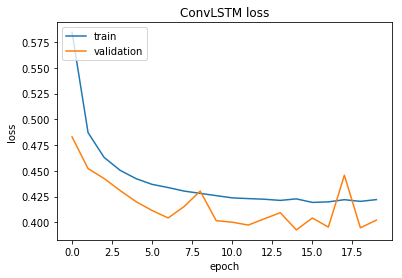

In [ ]:
# Build CNN + LSTM Hybrid model

input = Input(shape=(23,1))

cnn=SeparableConv1D(64,3,activation='relu')(input)
maxp=MaxPooling1D()(cnn)

cnn=SeparableConv1D(128,3,activation='relu')(maxp)
maxp=MaxPooling1D()(cnn)

lstm=LSTM(16)(maxp)

d=Dense(128, activation='relu')(lstm)
d=Dropout(0.4)(d)

d=Dense(256, activation='relu')(d)
d=Dropout(0.4)(d)

d=Dense(512, activation='relu')(d)

# Dense layer that has a softmax activation function
output = Dense(13, activation='softmax')(d)

model = Model(inputs=input, outputs=output)

# defining learning rate and optimizer
adam=Adam(lr=0.001)

# compiling model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train,y_train,batch_size=32, epochs=20,validation_data=(X_test,y_test))

# saving model
model.save('cnn-lstm.h5')

with open("OH", 'wb') as fp:
    pickle.dump(oh, fp)


# plotting stats of model
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ConvLSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("cnn-lstm-loss.png")

with open("X_test-cnn-lstm", 'wb') as fp:
    pickle.dump(X_test, fp)

with open("y_test_cnn-lstm", 'wb') as fp:
    pickle.dump(y_test, fp)

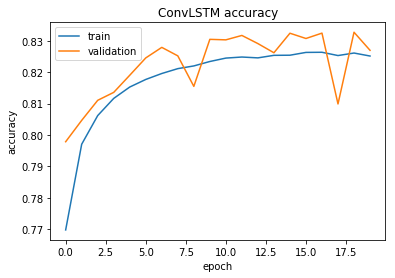

In [ ]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ConvLSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("cnn-lstm-acc.png")

In [ ]:
import pickle
import numpy as np

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix


# getting data
with open('X_test-cnn-lstm', 'rb') as fp:
    X_test=pickle.load(fp)

with open('y_test_cnn-lstm', 'rb') as fp:
    y_test=pickle.load(fp)


# load model whose conf matrix you want
model=load_model('cnn-lstm.h5')

# make predictions
y_pred=model.predict(X_test)


# 12 total classes
labs=set()
labs.add(0)
labs.add(1)
labs.add(2)
labs.add(3)
labs.add(4)
labs.add(5)
labs.add(6)
labs.add(7)
labs.add(8)
labs.add(9)
labs.add(10)
labs.add(11)
labs.add(12)

preds=[]
new_test=[]

# converting one hot prediction and real label to single integer value
for i,p in enumerate(y_pred):
    preds.append(np.argmax(p))
    new_test.append(np.argmax(y_test[i]))

y_pred=preds
y_test=new_test

# making conf matrix
array=confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in list(labs)],
                  columns = [i for i in list(labs)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')

# saving matrix
plt.title("Confusion Matrix: ConvLSTM")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("CM-lstmCNN.png")

In [ ]:
# print models layers
print(model.layers)

[<keras.engine.input_layer.InputLayer object at 0x7fbebac6ce80>, <keras.layers.convolutional.SeparableConv1D object at 0x7fbebac6cef0>, <keras.layers.pooling.MaxPooling1D object at 0x7fbebaca22e8>, <keras.layers.convolutional.SeparableConv1D object at 0x7fbebaca2400>, <keras.layers.pooling.MaxPooling1D object at 0x7fbebaca2748>, <keras.layers.recurrent.LSTM object at 0x7fbebaca2898>, <keras.layers.core.Dense object at 0x7fbebaca2b00>, <keras.layers.core.Dropout object at 0x7fbebaca2c50>, <keras.layers.core.Dense object at 0x7fbebaca2c88>, <keras.layers.core.Dropout object at 0x7fbebaca2dd8>, <keras.layers.core.Dense object at 0x7fbebaca2e10>, <keras.layers.core.Dense object at 0x7fbebaca2f60>]


In [ ]:
# print models input layer
print(model.input)

Tensor("input_2_1:0", shape=(?, 23, 1), dtype=float32)


In [ ]:
# print models output layer
print(model.outputs)

[<tf.Tensor 'dense_8_1/Softmax:0' shape=(?, 13) dtype=float32>]


In [ ]:
# summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23, 1)             0         
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 21, 64)            131       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
separable_conv1d_4 (Separabl (None, 8, 128)            8512      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2176      
__________

In [ ]:
from sklearn.metrics import classification_report

classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

print(classification_report(y_test, y_pred, target_names=classes))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

               Null class       0.88      0.89      0.89    174577
           Standing still       0.68      0.95      0.79      6131
     Sitting and relaxing       0.71      1.00      0.83      6033
               Lying down       0.75      1.00      0.86      6140
                  Walking       0.78      0.25      0.37      6285
          Climbing stairs       0.73      0.11      0.19      6198
      Waist bends forward       0.65      0.73      0.69      5640
Frontal elevation of arms       0.70      0.83      0.76      5859
Knees bending (crouching)       0.68      0.58      0.62      5895
                  Cycling       0.68      0.76      0.72      6080
                  Jogging       0.66      0.52      0.58      6074
                  Running       0.57      0.85      0.68      6173
        Jump front & back       0.00      0.00      0.00      2064

                 accuracy                           0.83    

In [ ]:
# Results
from sklearn import metrics
from numpy import argmax
from sklearn.metrics import accuracy_score

print("ConvLSTM - Accuracy:{}%".format(100*accuracy_score(y_test, y_pred)))

print("")
print("ConvLSTM - Precision: {}%".format(100*metrics.precision_score(y_test, y_pred, average="weighted")))
print("ConvLSTM - Recall: {}%".format(100*metrics.recall_score(y_test, y_pred, average="weighted")))
print("ConvLSTM - f1_score: {}%".format(100*metrics.f1_score(y_test, y_pred, average="weighted")))

print("")
print("Confusion Matrix: ConvLSTM")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

ConvLSTM - Accuracy:84.61642860961797%



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ConvLSTM - Precision: 84.32357374326016%
ConvLSTM - Recall: 84.61642860961797%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ConvLSTM - f1_score: 84.14273256510552%

Confusion Matrix: ConvLSTM
[[154901   2516   2343   1909   1062   1735   1644   1610   1083   2094
    1601   2111      0]
 [   291   6007      0      0      0      0      0      0      0      0
       0      0      0]
 [    33      0   6071      0      0      0      0      0      0      0
       0      0      0]
 [     7      0      0   6066      0      0      0      0      0      0
       0      0      0]
 [  3131      0      0      0   3060     20      0      0      1      0
       0      0      0]
 [  2919      0      0      0     28   3236      2      0     23      9
       3      1      0]
 [  1635      9      0      0      0      0   3968      2     20      0
       0      0      0]
 [  1288      3      0      0      0      0      0   4564      0      0
       0      0      0]
 [  2645      1      0      1     11     86      7      1   3071      0
       0      0      0]
 [  1008      0      4      0      0      8      0      0      5   5

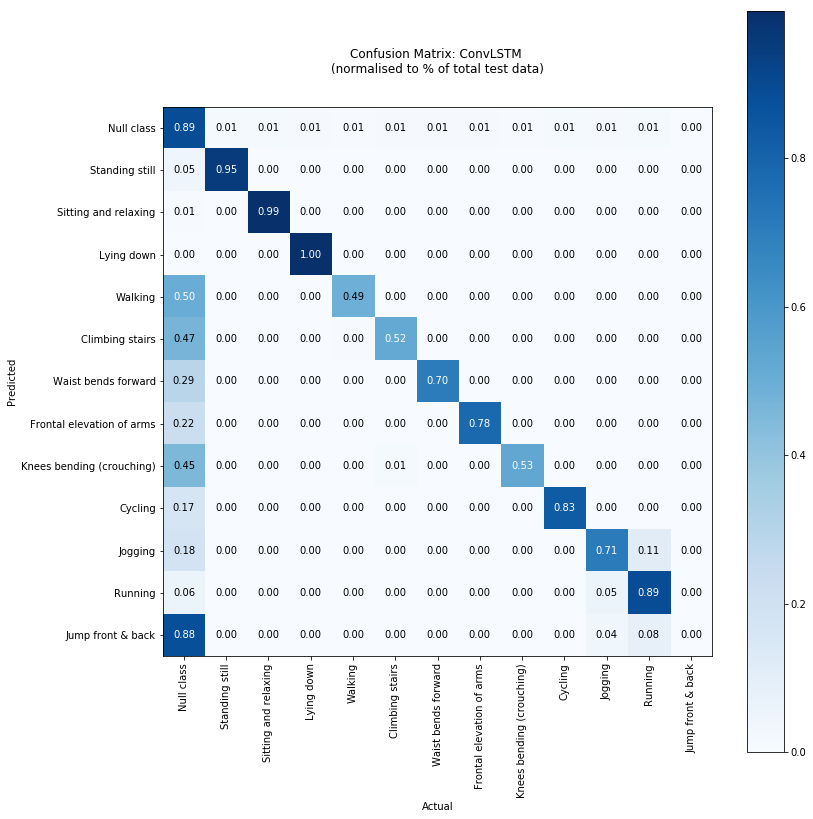

In [ ]:
# The following feature importance code is taken from this link. 
# Referenced in thesis
# https://www.oipapio.com/question-3935333

# Import libraries
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convert cm to array for multiclass cm
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
multiclass = normalised_confusion_matrix

# labels (classes)
classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize = (12,12))

# plot title, xaxis and yaxis, identify tickmarks, ensure tight layout
plt.title('Confusion Matrix: ConvLSTM \n(normalised to % of total test data)')
plt.xlabel("Actual")
plt.ylabel("Predicted")
tick_marks = np.arange(13)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.show()

In [ ]:
# Bar chart feature importance

from sklearn.metrics import confusion_matrix as cm
import pandas as pd

# confusion matrix
confusion_matrix=cm(y_test, y_pred)

# Create list containing labels for dataframe below
list1 = ["Null class","Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]
list2 = ["Null class","Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# convert to pandas dataframe
pd.DataFrame(confusion_matrix, list1,list2)

df = pd.DataFrame(confusion_matrix, list1,list2)
# Hard code in accuracy
df['Accuracy'] = ['88%','96%','100%','99%','56%','41%','82%','82%','71%','78%','72%','79%','4%']
df = df[1:14]
df

,Unclassified,Standing still,Sitting and relaxing,Lying down,Walking,Climbing stairs,Waist bends forward,Frontal elevation of arms,Knees bending (crouching),Cycling,Jogging,Running,Jump front & back,Accuracy
Standing still,652,5535,0,0,0,0,4,0,0,0,0,0,0,96%
Sitting and relaxing,46,0,6102,0,0,0,0,0,0,0,0,0,0,100%
Lying down,23,0,0,6078,0,0,0,0,0,0,0,0,0,99%
Walking,4371,0,0,0,1811,11,1,0,2,0,0,0,0,56%
Climbing stairs,3513,0,0,0,11,2495,9,0,50,2,4,0,0,41%
Waist bends forward,1286,2,0,0,0,0,4370,2,12,0,0,0,0,82%
Frontal elevation of arms,1153,1,0,0,0,0,13,4717,0,0,0,0,0,82%
Knees bending (crouching),2139,0,0,0,17,33,50,0,3674,0,0,0,0,71%
Cycling,2121,0,0,0,0,1,0,0,11,3985,0,0,0,78%
Jogging,1216,0,0,0,0,1,0,0,0,0,4432,556,2,72%


In [ ]:
# The following feature importance code is taken from this link. 
# Referenced in thesis
# https://www.oipapio.com/question-3935333

# import libraries
from xgboost import plot_importance,XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# import libraries
import numpy as np 
from xgboost import XGBClassifier 

# Set number of estimators
xgb = XGBClassifier(n_estimators=100) 

# feature importance train test split
X_train,X_test,y_train,y_test=model_selection.train_test_split(features,labels,test_size=0.2)

# fit the model, set evaluation set and early stopping rounds
xgb = xgb.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)])

[0]	validation_0-merror:0.251183
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.250435
[2]	validation_0-merror:0.250501
[3]	validation_0-merror:0.250233
[4]	validation_0-merror:0.249818
[5]	validation_0-merror:0.249119
[6]	validation_0-merror:0.249341
[7]	validation_0-merror:0.249526
[8]	validation_0-merror:0.249485
[9]	validation_0-merror:0.249156
[10]	validation_0-merror:0.248272
[11]	validation_0-merror:0.248288
[12]	validation_0-merror:0.247507
[13]	validation_0-merror:0.245977
[14]	validation_0-merror:0.244916
[15]	validation_0-merror:0.244833
[16]	validation_0-merror:0.24179
[17]	validation_0-merror:0.240532
[18]	validation_0-merror:0.23961
[19]	validation_0-merror:0.238681
[20]	validation_0-merror:0.238019
[21]	validation_0-merror:0.237159
[22]	validation_0-merror:0.237188
[23]	validation_0-merror:0.235197
[24]	validation_0-merror:0.234741
[25]	validation_0-merror:0.234182
[26]	validation_0-merror:0.233285
[27]	validation_0-merror:0.2

    feature  importance
3       f8         730
4      f18         708
5      f15         690
1      f17         614
10      f2         596
8      f19         561
9      f11         506
2      f14         472
0       f0         456
6      f10         439
7       f7         438
11      f9         402
13     f16         369
15     f22         336
12     f20         283
17      f6         257
19     f13         248
20     f12         198
14      f1         167
18     f21         162
16      f5         137
21      f4          94
22      f3          44


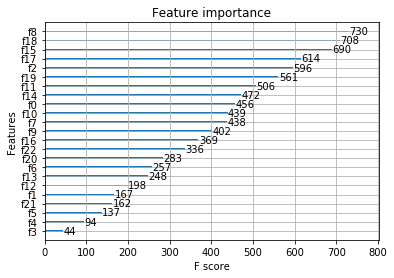

In [ ]:
# import library
import pandas as pd

# fit model
xgb_model=xgb.fit(X_train,y_train)

# convert to pandas dataframe. assign 'feature' and 'importance columns'
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()),
                                           
columns=['feature','importance']).sort_values('importance', ascending=False)

# print feature importance for each attribute
print('',xgb_fea_imp)

# plot importance
from xgboost import plot_importance
plot_importance(xgb_model, )